# Sentence Completion
This notebook is used for a final project as a part of the CS 4980 Natural Language Processing course at the Milwaukee School of Engineering during the spring term of 2023. This notebook was created by [Grant Fass](grantfass@gmail.com) and [Nicholas Kaja](kajan@msoe.edu). The following notebook will explore the problem of natural language sentence completion.

Natural language sentence completion involves determining what word best fits in a blank present in a sentence. This type of question is typically found on the Scholastic Aptitude Test (SAT). It is useful because it can measure the performance of a language model (LM) on questions that educational experts deem important. LMs that perform well on this type of problem will likely perform better on broader tasks.

The primary method for forming a sentence completion model is to compute the probability of each possible sentence tehn choose the most probable option. This probability computation can be done using n-grams, Latent Semantic Analysis (LSA), and Syntactic Dependency Trees. Some research has also been done into combining these with methods of preserving long-range dependencies in the sentences. Of these options, N-grams is one of the easiest starting points due to its ease of implementation and understanding. N-grams also allow for sufficient variations over the base model such as different N-gram algorithms, different values of N, and different methods of tokenization.

We will be constructing our models from a dataset of Khan Academy lecture transcripts. This dataset was scraped using BeautifulSoup during January of 2023 by Nicholas Kaja as a part of a senior design project. The performance of our model will be evaluated on a [SAT Question Dataset](https://github.com/ctr4si/sentence-completion/tree/master/data/completion). After evaluation, we plan to take our best performing model and apply it to sentence generation. This will allow us to get a better feel for how well it performs. Once our model is working, we also plan to implement some additional features such as Named Entity Recognition (NER). If there is enough time we also plan to investigate using the [OpenAI tokenizer](https://platform.openai.com/tokenizer) instead of the [NLTK Word Tokenizer](https://www.nltk.org/api/nltk.tokenize.html) or the [SpaCy Tokenizer](https://spacy.io/api/tokenizer). The OpenAI tokenizer has a [python package found on github](https://github.com/openai/tiktoken).

For more information please see the Data Collection And Processing document as well as the Project Background document. Both of these documents can be found in the repository under the Sentence Completion directory.

## Imports
Below are sample imports based on other NLP tasks.

In [1]:
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import random
from tqdm import tqdm
import nltk
from nltk.util import ngrams
import re
import contractions
import unidecode
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import math
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
])

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
encoder = LabelEncoder()

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kajan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up

## Data Loading  
Combine all domains into a single DataFrame

In [2]:
computing = pd.read_csv("Datasets\\KhanAcademy\\Computing.csv")
computing = computing.dropna()

economics = pd.read_csv("Datasets\\KhanAcademy\\Economics.csv")
economics = economics.dropna()

humanities = pd.read_csv("Datasets\\KhanAcademy\\Humanities.csv")
humanities = humanities.dropna()

math = pd.read_csv("Datasets\\KhanAcademy\\Math.csv")
math = math.dropna()

science = pd.read_csv("Datasets\\KhanAcademy\\Science.csv")
science = science.dropna()

khan_dfs = [computing, economics, humanities, math, science]
khan = pd.concat(khan_dfs, axis=0)

## Cleaning
Decided to just remove the first sentence from every transcript. This guarantees that we catch all of the tags like "[Instructor]" or "- Speaker 1:"  
Most of the first sentences are greetings / introdcutions - not very useful information.

In [3]:
def remove_first_sentence(doc):
    """
    This removes the first sentence of a document. We use this to remove all narrator / speaker tags, and
    to remove unnecessary introductory sentences that most transcripts have
    """
    return ' '.join(nltk.sent_tokenize(doc)[1:])

In [4]:
def remove_bracket_tags(doc):
    """
    This gets rid of any remaining tags in the transcript such as (music) or [clicking]
    """
    return re.sub(r"\s{2,}", " ", re.sub(r"[\(\[\{][^\)\]\}]*[\)\]\}]", "", doc))

In [5]:
khan['clean_transcript'] = khan['transcript'].apply(remove_first_sentence).apply(remove_bracket_tags)

## N-Grams

In [6]:
tokens = []
corpus = khan['clean_transcript'].values
for document in tqdm(corpus):
    tokens += nltk.word_tokenize(document)

100%|█████████████████████████████████████████████████████████████████████████████| 8261/8261 [01:07<00:00, 122.32it/s]


In [7]:
n = 4
quadgrams = list(ngrams(tokens, n))
fdist = nltk.FreqDist(quadgrams)

In [8]:
MASK = "_____" # SAT Dataset uses 5 underscores as the mask token

def fill(fdist: nltk.FreqDist, prompt: str, candidates: list, mask: str=MASK, verbose: bool=False):
    """
    Returns the token from the candidates list that is most likely to fill in the <MASK> of the prompt
    based on the frequency distribution of the ngrams model

            Parameters:
                    fdist (nltk.FreqDist): The frequency distributions of the ngram model
                    prompt (str): The prompt string. Must include a <MASK> token
                    candidates (list): A list of candidates to potentially fill the <MASK> token
                    mask (str): The mask token used by the prompt
                    verbose (bool): Whether to print the sliding window grams

            Returns:
                    candidate (str): The candidate highest probability (frequency) to fill in the <MASK> token
    """
    prompt_tokens = nltk.word_tokenize(prompt)
    if mask not in prompt_tokens:
        raise ValueError(f"Prompt doesn't include mask token: {mask}")
    mask_index = prompt_tokens.index(mask)

    probs = {}
    for candidate in candidates:
        context_probs = []
        for i in range(n):        
            context = tuple(prompt_tokens[max(0,mask_index-n+i+1):mask_index] + \
                            [candidate] + \
                            prompt_tokens[mask_index+1:min(mask_index+i+1,len(prompt_tokens))])
            context_probs.append(fdist[context])
            if len(context) == n and verbose:
                print(context, fdist[context])

        probs[candidate] = 0
        for p in context_probs:
            probs[candidate] += p
            
    return max(probs, key=probs.get)

In [9]:
question = "This is something that you don't _____ to happen"
candidates = ['want','expect','need','like']

fill(fdist, question, candidates, verbose=True)

('you', 'do', "n't", 'want') 113
('do', "n't", 'want', 'to') 898
("n't", 'want', 'to', 'happen') 0
('you', 'do', "n't", 'expect') 1
('do', "n't", 'expect', 'to') 1
("n't", 'expect', 'to', 'happen') 0
('you', 'do', "n't", 'need') 56
('do', "n't", 'need', 'to') 88
("n't", 'need', 'to', 'happen') 0
('you', 'do', "n't", 'like') 20
('do', "n't", 'like', 'to') 17
("n't", 'like', 'to', 'happen') 0


'want'

## SAT Dataset

In [10]:
SAT = pd.read_csv("Datasets\\SAT_Question_Dataset.csv")
SAT = SAT[SAT['blanks'] == 1].reset_index(drop=True) # Filtering to only single blank sentences right now

In [11]:
def get_answer_token(masked, original, mask=MASK):
    tokens = nltk.word_tokenize(original)
    masked_tokens = nltk.word_tokenize(masked)
    
    result = tokens[masked_tokens.index(mask)]
    if result in ['a','an']:
        result = tokens[masked_tokens.index(mask) + 1]
    
    return result

In [12]:
for letter in ['a','b','c','d','e']:
    SAT[letter] = SAT.apply(lambda x: get_answer_token(x['question'], x[letter+')']), axis=1)

In [13]:
SAT.head()

,id,ans,question,a),b),c),d),e),year,sec,num,diff,blanks,a,b,c,d,e
0,4,e,"During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...",2001,1,4,3,1,intransigence,plenitude,desecration,stagnation,renaissance
1,6,a,"Luisa worked with extreme precision, _____ tha...","Luisa worked with extreme precision, a meticul...","Luisa worked with extreme precision, an effron...","Luisa worked with extreme precision, an inhibi...","Luisa worked with extreme precision, a litigio...","Luisa worked with extreme precision, an impetu...",2001,1,6,3,1,meticulousness,effrontery,inhibition,litigiousness,impetuousness
2,7,a,"The crafty child tricked his innocent brother,...","The crafty child tricked his innocent brother,...","The crafty child tricked his innocent brother,...","The crafty child tricked his innocent brother,...","The crafty child tricked his innocent brother,...","The crafty child tricked his innocent brother,...",2001,1,7,3,1,guileless,intrusive,astute,opportunistic,circumspect
3,8,e,Ellen Ochoa's _____ with the apparatus in the ...,Ellen Ochoa's compromise with the apparatus in...,Ellen Ochoa's humility with the apparatus in t...,Ellen Ochoa's machinations with the apparatus ...,Ellen Ochoa's synergy with the apparatus in th...,Ellen Ochoa's deftness with the apparatus in t...,2001,1,8,5,1,compromise,humility,machinations,synergy,deftness
4,9,d,In 1916 Yellowstone National Park had only 25 ...,In 1916 Yellowstone National Park had only 25 ...,In 1916 Yellowstone National Park had only 25 ...,In 1916 Yellowstone National Park had only 25 ...,In 1916 Yellowstone National Park had only 25 ...,In 1916 Yellowstone National Park had only 25 ...,2001,1,9,5,1,dispersed,mediated,attenuated,burgeoned,reconciled


In [14]:
answers = []

for idx, record in SAT.iterrows():
    candidates = record[['a','b','c','d','e']].values
    prompt = record['question']
    
    pred_word = fill(fdist, prompt, candidates)
    answer = ['a','b','c','d','e'][np.where(candidates == pred_word)[0][0]]
    answers.append(answer)

In [15]:
np.mean(np.array(answers) == SAT['ans']) # Accuracy

0.23809523809523808

In [16]:
SAT['ans'].value_counts(normalize=True)

a    0.238095
c    0.226190
b    0.190476
e    0.178571
d    0.166667
Name: ans, dtype: float64

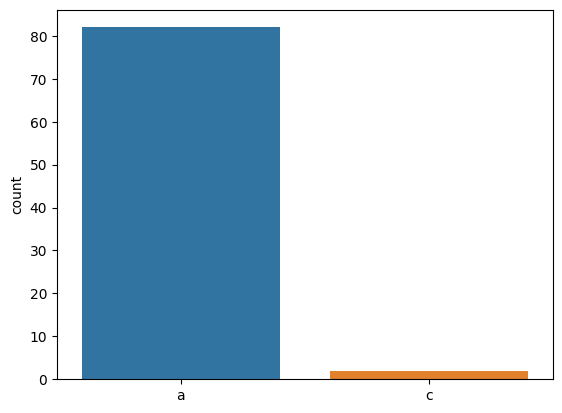

In [17]:
sns.countplot(x=answers)
plt.show()

As expected, the model isn't familiar with a lot of these words and phrases, so it defaults to the first answer most of the time. As a result, the accuracy is pretty much just the percentage of questions with the answer a)